## face recognition using classic multiclass classification
Training data: pictures of different persons, each person is a class
Prediction: given a picture, we compute the probability of the person 


data: 20 pictures per person, 5 persons

## two approaches:

1. Develop a network by hand, do the training directly. 
2. Using the pretrained network (transfer training)

In [1]:
# Data
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/val"

In [2]:
# os.getcwd()

In [3]:
# a function to check so as to list only the directory
def listDirOnly(path): 
    return [filename for filename in os.listdir(path) if os.path.isdir(os.path.join(path, filename))]

# a function to list solely the 'jpg' images (i.e. get a python list)
def listJPGImages(path):
    # very specific to our case
    return [filename for filename in os.listdir(path) if filename.endswith(".jpg") ]

In [4]:
# everything under TRAIN_DIR is really an directory (it is not a single file)
os.listdir(TRAIN_DIR), listDirOnly(TRAIN_DIR)

(['ben_afflek', 'madonna', 'elton_john', 'mindy_kaling', 'jerry_seinfeld'],
 ['ben_afflek', 'madonna', 'elton_john', 'mindy_kaling', 'jerry_seinfeld'])

In [5]:
listJPGImages(os.path.join(TRAIN_DIR, 'ben_afflek'))

['httpcsvkmeuaeccjpg.jpg',
 'httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg',
 'httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg',
 'httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg',
 'httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg',
 'httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg',
 'httptrwebimgacstanetcxbdddmediasnmediajpg.jpg',
 'httpwwwhillsindcomstorebenjpg.jpg',
 'httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg',
 'httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg',
 'httpwwwrumenewscomwpcontentuploadsbenafflekxpng.jpg',
 'httpwwwallposterscomimagesPostersPFjpg.jpg',
 'httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg',
 'httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg']

In [6]:
# class_list: a list of class, in the sense of classification (machine learning, face recognition)
class_list = np.sort(np.unique(listDirOnly(TRAIN_DIR)))
print class_list

['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling']


In [7]:
# now construct the data, let's use list to contain the image
# later we will reshape them as needed
import cv2

def generateData(path, class_list):  # output is a list of 3d-array, one 3d-array represents one image
    data = [] # the order of the data is the same as the class list
    for label in class_list:
        target_dir = os.path.join(path, label)
        images = listJPGImages(target_dir)
        data.append([cv2.imread(os.path.join(target_dir, image)) for image in images])
    return data

In [8]:
data_train = generateData(TRAIN_DIR, class_list)
data_test = generateData(TEST_DIR, class_list)

print len(data_train[0])
print data_train[0][0].shape

14
(170, 115, 3)


First off, we preprocess and image by cv2.imread，and then detect the face by Haar Cascade in 
opencv library in python (cv2 package). Note that Haar Cascade would return a matching score

### Handling the tilted face
The idea is to rotate a photo from -60 to 60, detect the one with the best matching score, then crop the best one by Haar Cascade, and return it. 


In [9]:
# preprocessing data, locate the faces
# given the picture, rotate it from -60 to 60, find the face with the best matching score
# crop the one, return the cropped face

def rotate_image_without_crop(image, angle):
    
    (h, w) = image.shape[:2] # h: height;  w: width
    (cX, cY) = (w / 2., h / 2.) # cX: center of X; 
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv2.warpAffine(image, M, (nW, nH))

def crop_image(img, faceR):
    (x, y, w, h) = faceR
    return img[y:y+h, x:x+w].copy()

def detect_face(image):
#     cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml")

    cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt.xml")
    result = None
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(cascadePath)
    
    angle_range = np.arange(-60, 60, 5)
    
    best_face = None
    best_angle = None
    max_weight = 0
    for angle in angle_range:
        imageGray_rotated = rotate_image_without_crop(imageGray, angle)
        # there may be multiple faces in a pic
        # larger minNeighbors means lower false postive
        faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray_rotated, 
                                                                          scaleFactor=1.05, minNeighbors=3, 
                                                                          minSize=(5,5), outputRejectLevels=True)
    
        if len(faceRects) <= 0:
            continue
        else:
            # for all the faces detected in a pic, find the largest shape one. It is our assumption
            # when doing prediciton, it is of course not a problem to do multiple face detection
            # but in training, it is hard to believe there are two faces of the same person.
            face, weight = max([(faceR, weight) for faceR, weight in zip(faceRects, levelWeights)], 
                               key = lambda x: x[0][2]*x[0][3]) 
#             print weight, angle
            if (weight > max_weight):
                max_weight = weight
                best_face = face
                best_angle = angle
    
    if(best_face is None):
        return None
    else:
        rotated_img = rotate_image_without_crop(image, best_angle)
        return crop_image(rotated_img, best_face)
    

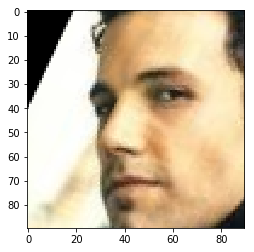

In [10]:
image = cv2.imread(TRAIN_DIR + '/ben_afflek/httpcsvkmeuaeccjpg.jpg')
detected_face = detect_face(image)
plt.imshow(detected_face[:,:,::-1])
plt.show()

### define our model system

For the training part (training data), we call detect_face and save the result for training. 

In terms of prediction (testing data), we use the same face detection function to find the face, then feed them to the model

In [11]:
# training and validation data
def generateAlignedData(data_list):
    result = []
    for images in data_list:
        temp = []
        for image in images:
            aligned_image = detect_face(image)
            assert(aligned_image is not None)
            temp.append(aligned_image)
        result.append(temp)
    return result

In [12]:
data_train_aligned = generateAlignedData(data_train)
data_test_aligned = generateAlignedData(data_test)

In [13]:
# len(data_train_aligned)
np.shape(data_train_aligned)

(5,)

The following is a function could resize the photo and append the label to each photo.

In [14]:
def img_resize_prepare(image_list, class_list, size):
    # change to gray image
    result = []
    for index, images in enumerate(image_list):
        for image in images:
            result.append((cv2.resize(image, size), class_list[index]))
    return result

#### Dumping (Saving locally) 
Dump the training and testing data to two pickle files on the disk. 

In [15]:
data_train_aligned_to_save224 = img_resize_prepare(data_train_aligned, class_list, (224, 224))
data_test_aligned_to_save224 = img_resize_prepare(data_test_aligned, class_list, (224, 224))

import os, errno

try:
    os.makedirs('data_dumped')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

import pickle
pickle.dump(data_train_aligned_to_save224, open("data_dumped/image_data_train224.pkl","wb"))
pickle.dump(data_test_aligned_to_save224, open("data_dumped/image_data_test224.pkl","wb"))

pickle.dump(class_list, open("data_dumped/class_list.pkl", "wb"))

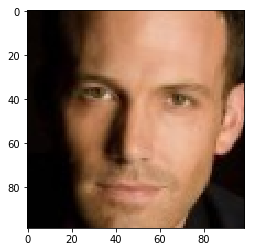

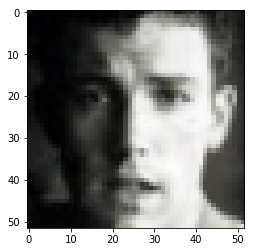

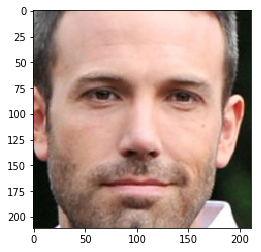

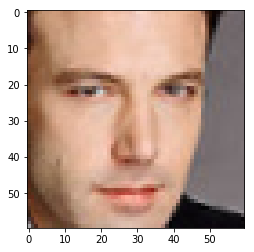

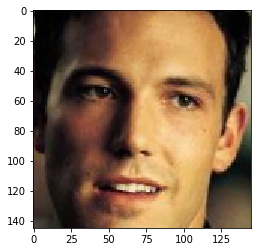

In [16]:
for image in data_test_aligned[0]:
    plt.imshow(image[:,:,::-1])
    plt.show()

Define a function convert a photo to the gray scale and resize it. In this way, 
1. a 3-channel photo is tranformed to a 1-channel photo. 
2. resizing simplifies the training and make it robust. We could check whether the resizing make sense by simply display the resized photo by eyes, to see whether it is still discernable. 

In [17]:
def to_gray_and_resize(image_list, size, class_list):
    # change to gray image
    # resize
    result = []
    for index, images in enumerate(image_list):
        for image in images:
            result.append((cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), size), class_list[index]))
    return result

In [18]:
# variable using long names on purpose, help with understanding the status
image_len = 28

data_train_aligned_gray_resized_with_label = to_gray_and_resize(data_train_aligned, (image_len, image_len), class_list)
data_test_aligned_gray_resized_with_label = to_gray_and_resize(data_test_aligned, (image_len, image_len), class_list)

We could check how the function works, by displaying the corresponding 5 photos we showed just now. 

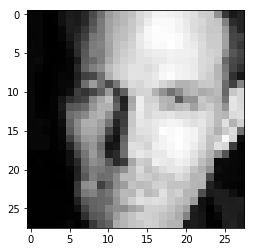

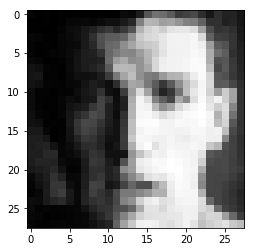

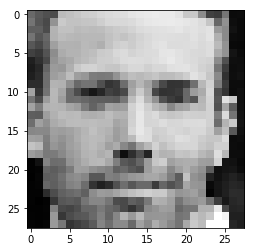

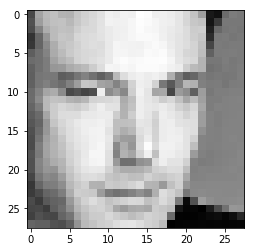

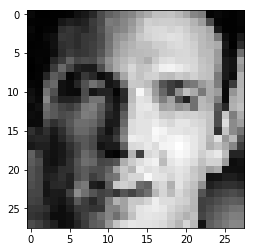

In [19]:
for (image, label) in data_test_aligned_gray_resized_with_label[:5]:
    plt.imshow(image, cmap='gray')
    plt.show()

In [20]:
# again, logistic regression
# neural network usually requires normalized input
X_train = np.array([x[0].reshape(image_len*image_len,) / 255. for x in data_train_aligned_gray_resized_with_label])
X_test = np.array([x[0].reshape(image_len*image_len,) / 255. for x in data_test_aligned_gray_resized_with_label])

Y_train = np.array([x[1] for x in data_train_aligned_gray_resized_with_label])
Y_test = np.array([x[1] for x in data_test_aligned_gray_resized_with_label])

print X_train.shape
print Y_train.shape

from collections import Counter
print Counter(Y_train)
print Counter(Y_test)

from sklearn.linear_model import LogisticRegression as LR

model = LR()
model.fit(X_train, Y_train)
print "scores from lr: ",  model.score(X_train, Y_train), model.score(X_test, Y_test)

(93, 784)
(93,)
Counter({'mindy_kaling': 22, 'jerry_seinfeld': 21, 'madonna': 19, 'elton_john': 17, 'ben_afflek': 14})
Counter({'madonna': 5, 'ben_afflek': 5, 'elton_john': 5, 'jerry_seinfeld': 5, 'mindy_kaling': 5})
scores from lr:  1.0 0.76


/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Neural Network (normalization)

In [21]:
# now let's generate the data that can be fed into the network we used for mnist
train_data_final = data_train_aligned_gray_resized_with_label[:]

np.random.shuffle(train_data_final)

In [22]:
import tensorflow as tf
import numpy as np
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# with some minor changes
def create_network_2(input_dimension=image_len*image_len, output_dimension=5):
    # tf Graph input
    reset_graph()
    X = tf.placeholder(tf.float32, [None, image_len, image_len])
    X_reshaped = tf.reshape(X, shape=[-1, image_len, image_len, 1]) # what does the -1 mean? Why we need this? X is NOT only one image
    Y = tf.placeholder(tf.float32, [None, output_dimension])
    
    prob = tf.placeholder_with_default(1.0, shape=())
    
    # conv layer
    W_conv_1 = tf.Variable(tf.random_normal([3, 3, 1, 32])) # 3x3 filter, 32 filters, what does this 1 mean?
    prod_conv_1 = tf.nn.conv2d(X_reshaped, W_conv_1, strides=[1,1,1,1], padding='SAME', data_format='NHWC') # data format is default
    b_conv_1 = tf.Variable(tf.random_normal([32]))
    out_conv_1 = tf.nn.relu(tf.nn.bias_add(prod_conv_1, b_conv_1)) 
    
    # max pooling (guess which year is it invented? 30 years ago...)
    # "in all cases, pooling helps to make the representation approximately invariant to small translations"
    out_pool = tf.nn.max_pool(out_conv_1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
    
    # what is the dimension of the output of this layer?
    # dynamically determine the shape
    out_pool_dim = tf.reshape(out_pool[0],[-1]).get_shape().as_list()[0]
    
    # dense layer
    in_dense = tf.reshape(out_pool, [-1,out_pool_dim])
    
    # apply dropout, one way of regularization
    in_dense_dropout = tf.nn.dropout(in_dense, prob, seed=42)
    
    W_dense = tf.Variable(tf.random_normal([out_pool_dim, output_dimension]))
    b_dense = tf.Variable(tf.random_normal([output_dimension]))
                          
    out_dense = tf.add(tf.matmul(in_dense_dropout, W_dense), b_dense)
    prediction = tf.nn.softmax(out_dense)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_dense, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    train_op = optimizer.minimize(loss_op)
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    
    # saver = tf.train.Saver()
    return X, Y, prob, loss_op, train_op, accuracy, prediction, init


from sklearn.preprocessing import label_binarize # onehot-encoding the label (of classification)

def runNetwork(train_data, test_data, class_list, X, Y, prob, 
               loss_op, train_op, accuracy, prediction, init, num_steps = 2400, batch_size=40, display_step=200):
    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)
        
        X_train = np.array([x[0] for x in train_data])
        Y_train = label_binarize(np.array([x[1] for x in train_data]), class_list)
        N = len(X_train)
                        
        X_test = np.array([x[0] for x in test_data])
        Y_test = label_binarize(np.array([x[1] for x in test_data]), class_list)
        

        for step in range(1, num_steps+1):
            x = X_train[batch_size*(step-1)%N : batch_size*(step-1)%N+batch_size] # array of matrices (28 by 28)
            y_labels = Y_train[batch_size*(step-1)%N : batch_size*(step-1)%N+batch_size] # array of y_label
            # but for now y_label is not one-hot encoder
            y = label_binarize(y_labels, class_list)
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: x, Y: y, prob: 0.5})
            if step % display_step == 0 or step == 1:
                # Calculate training loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: Y_train})
                print "Step " + str(step) + ", Training Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc)
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_test, Y: Y_test})
                print "Step " + str(step) + ", Test Loss= " + \
                      "{:.4f}".format(loss) + ", Test Accuracy= " + \
                      "{:.3f}".format(acc)
                sys.stdout.flush()
        

        print "Optimization Finished! Step: ", step

        # Calculate accuracy for test set
        print "Testing Accuracy:", \
            sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})
            
        writer = tf.summary.FileWriter("./temp", graph=tf.get_default_graph())
            
        return sess.run(prediction, feed_dict={X: X_test, Y: Y_test})

reset_graph()                                
X, Y, prob, loss_op, train_op, accuracy, prediction, init = create_network_2()
predictions = runNetwork(train_data_final, data_test_aligned_gray_resized_with_label, class_list, X, Y, prob, loss_op, train_op, accuracy, prediction, init)                     
                        

Step 1, Training Loss= 46557.3477, Training Accuracy= 0.237
Step 1, Test Loss= 44448.3242, Test Accuracy= 0.200
Step 200, Training Loss= 9078.1934, Training Accuracy= 0.462
Step 200, Test Loss= 13181.9248, Test Accuracy= 0.360
Step 400, Training Loss= 5535.4917, Training Accuracy= 0.613
Step 400, Test Loss= 10420.8262, Test Accuracy= 0.440
Step 600, Training Loss= 3459.9368, Training Accuracy= 0.763
Step 600, Test Loss= 8283.6289, Test Accuracy= 0.520
Step 800, Training Loss= 2560.1641, Training Accuracy= 0.817
Step 800, Test Loss= 7382.9937, Test Accuracy= 0.520
Step 1000, Training Loss= 1955.2347, Training Accuracy= 0.839
Step 1000, Test Loss= 5992.1064, Test Accuracy= 0.520
Step 1200, Training Loss= 1459.1760, Training Accuracy= 0.903
Step 1200, Test Loss= 5102.1030, Test Accuracy= 0.600
Step 1400, Training Loss= 1128.0385, Training Accuracy= 0.903
Step 1400, Test Loss= 4259.0913, Test Accuracy= 0.600
Step 1600, Training Loss= 788.4457, Training Accuracy= 0.903
Step 1600, Test Loss=

predicted:  mindy_kaling ; actual:  ben_afflek


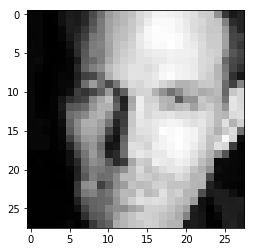

predicted:  mindy_kaling ; actual:  ben_afflek


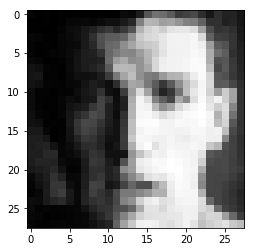

predicted:  mindy_kaling ; actual:  ben_afflek


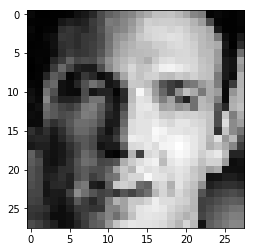

predicted:  madonna ; actual:  elton_john


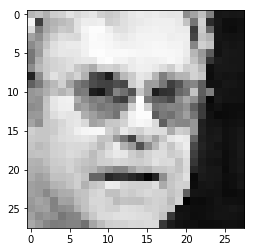

predicted:  mindy_kaling ; actual:  elton_john


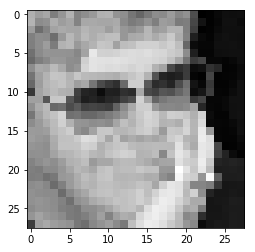

predicted:  madonna ; actual:  jerry_seinfeld


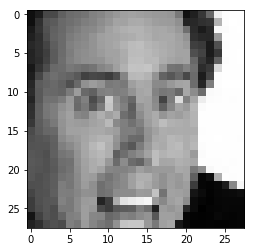

predicted:  madonna ; actual:  jerry_seinfeld


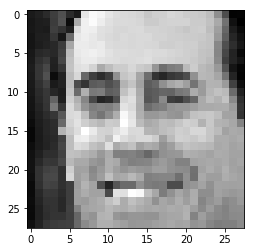

predicted:  jerry_seinfeld ; actual:  madonna


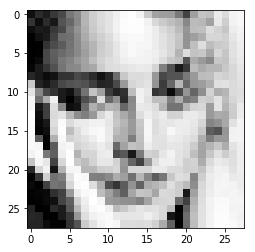

In [23]:
for (prediction, actual, x) in zip(predictions, Y_test, X_test):
    if class_list[np.argmax(prediction)] != actual:
        print "predicted: ", class_list[np.argmax(prediction)], "; actual: ", actual
        plt.imshow(x.reshape(image_len, image_len), cmap='gray')
        plt.show()

In [24]:
!tensorboard --logdir=./temp

TensorBoard 1.9.0 at http://leonards-MacBook-Pro.local:6006 (Press CTRL+C to quit)
^C


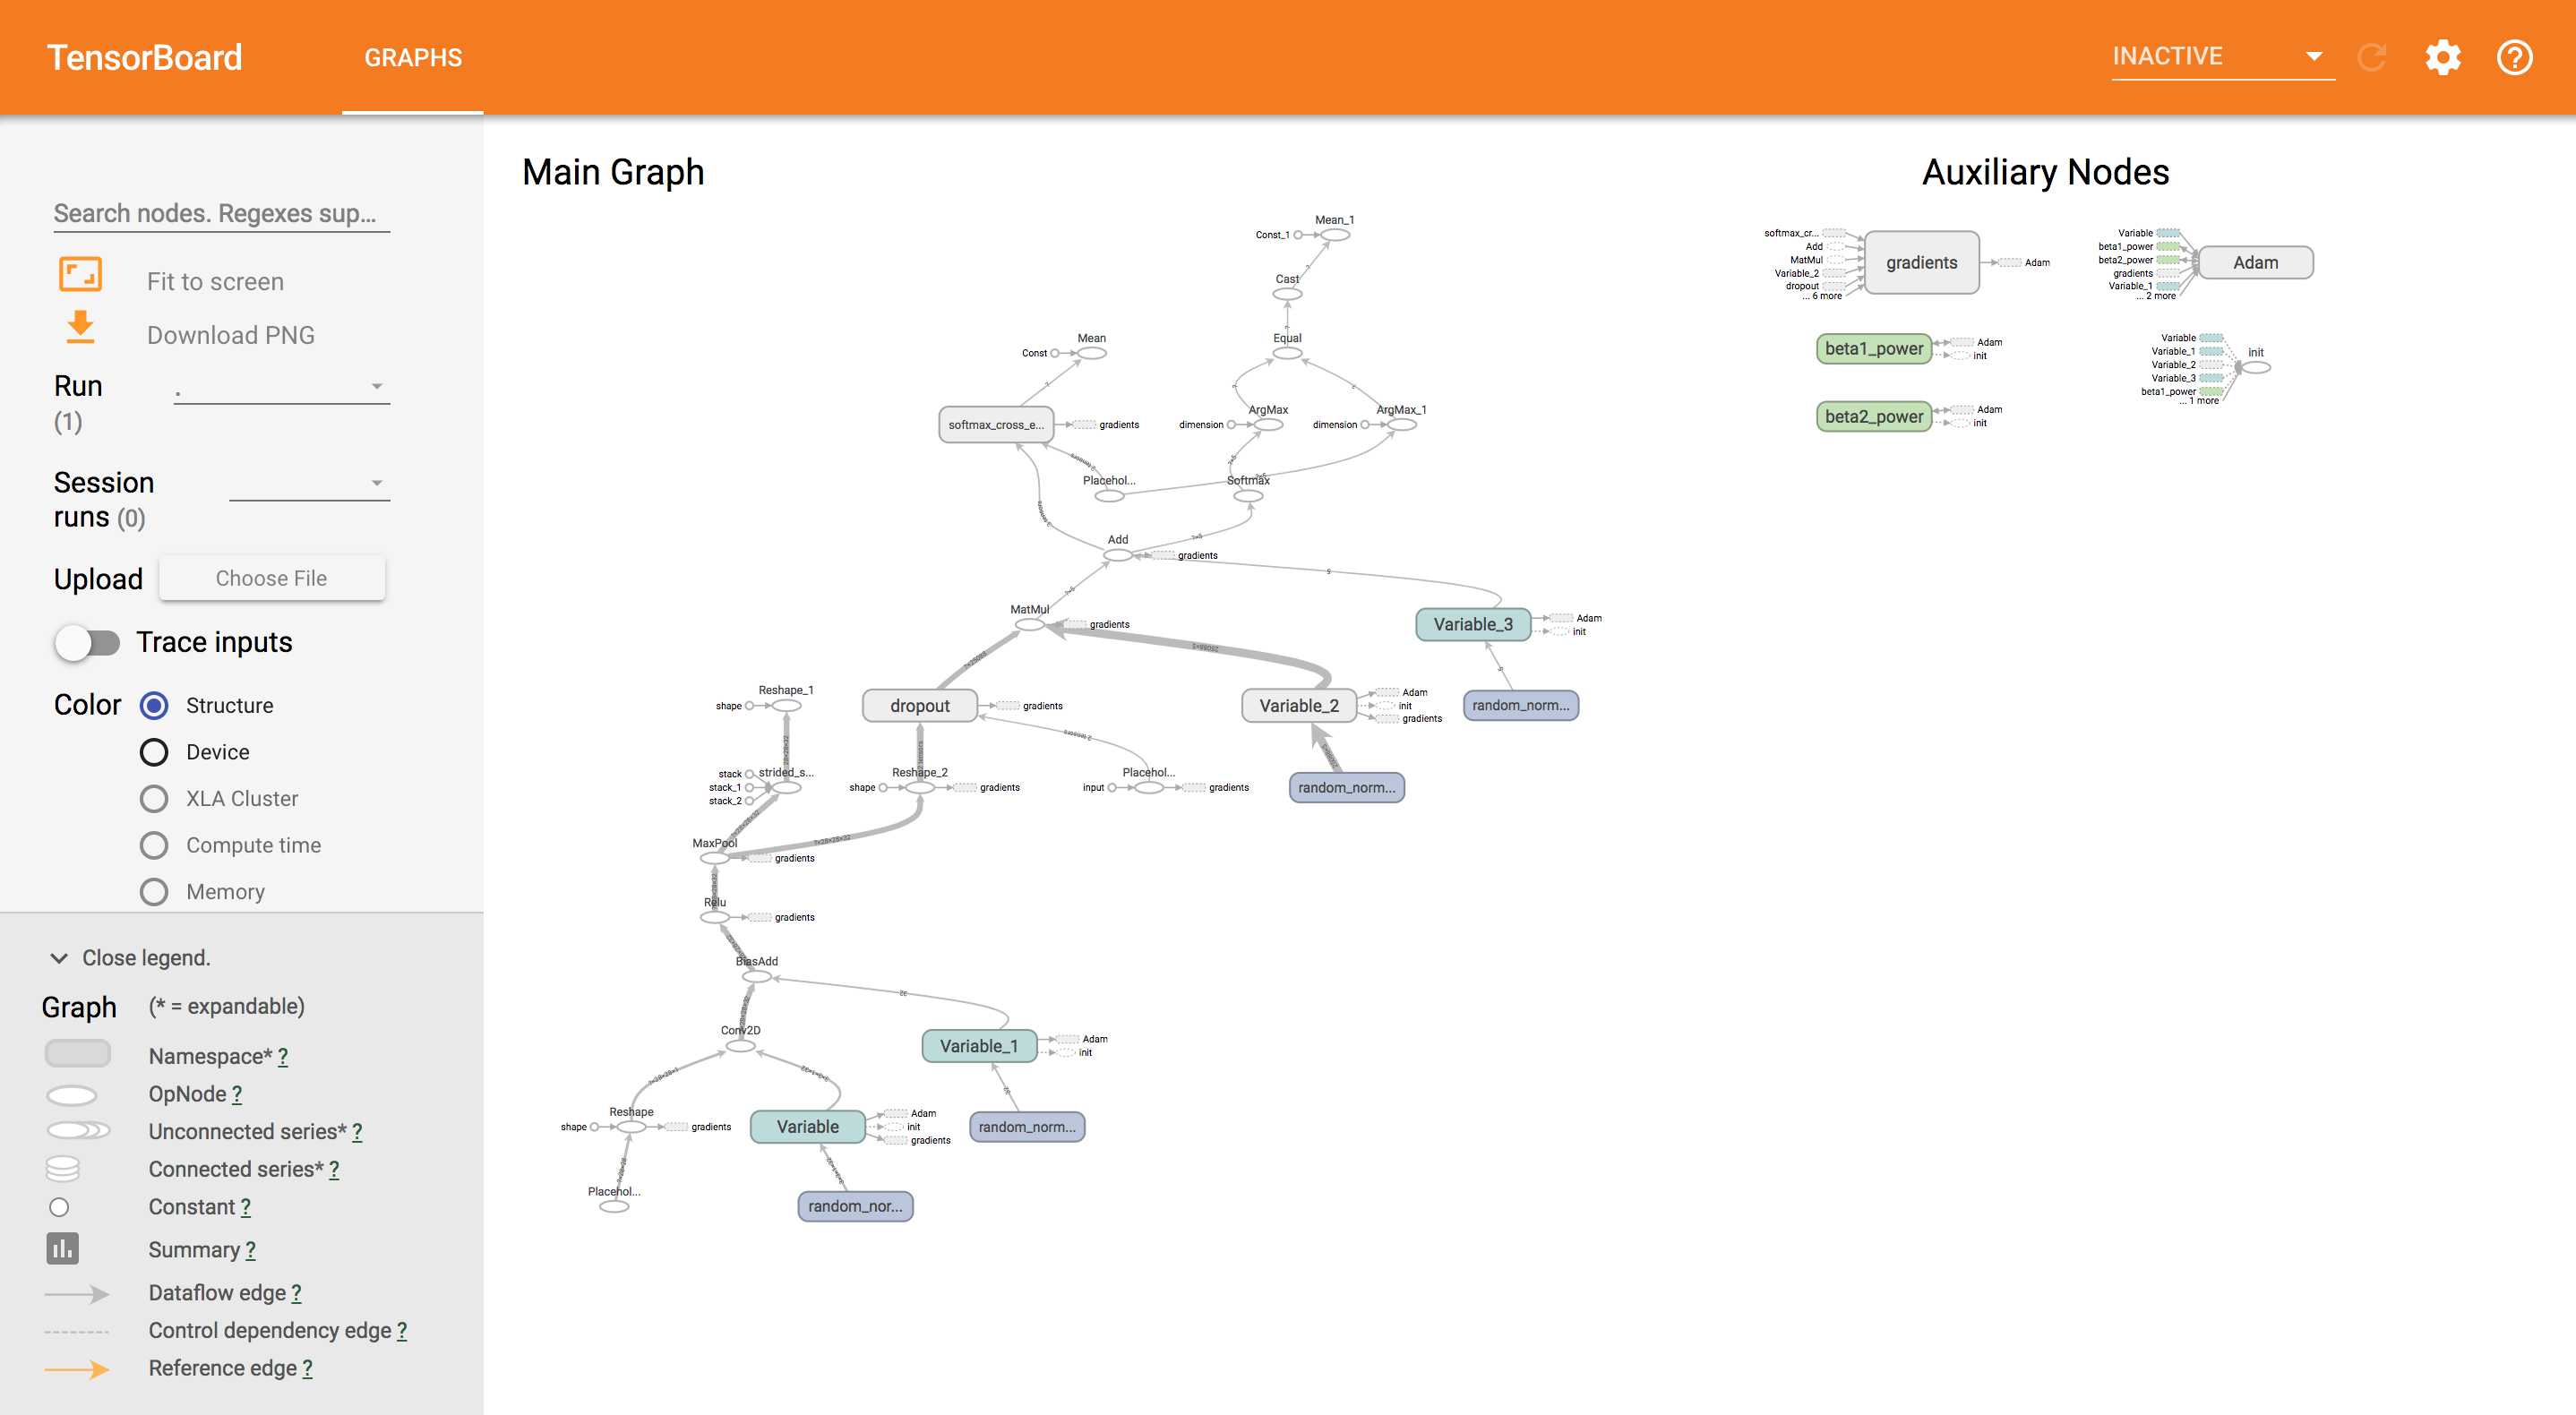